<a href="https://colab.research.google.com/github/pakkei1212/SMU_AML_PROJ/blob/stage_2_decision/No_Shows%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.7 MB/s eta 0:00:00


In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from xgboost import XGBClassifier
from hotel_preprocessing_orig import XYPreprocessor
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna


RANDOM_STATE = 2025
VERBOSE = 2

In [37]:
# === Load data and preprocess arrival date ===
raw_hotel_data = pd.read_csv("hotel_bookings.csv")
hotel_data = raw_hotel_data.copy()

hotel_data['arrival_date'] = pd.to_datetime(
    hotel_data['arrival_date_year'].astype(str) + '-' +
    hotel_data['arrival_date_month'] + '-' +
    hotel_data['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'
)
hotel_data['reservation_status_date'] = pd.to_datetime(hotel_data['reservation_status_date'])

# Define target: 1 if No-Show OR cancelled within 3 days before arrival, else 0
hotel_data['days_before_arrival'] = (hotel_data['arrival_date'] - hotel_data['reservation_status_date']).dt.days
hotel_data['late_or_noshow'] = ((hotel_data['reservation_status'] == 'No-Show') |
                                 ((hotel_data['reservation_status'] == 'Canceled') & (hotel_data['days_before_arrival'] <= 3))).astype(int)

# === Filter to only canceled reservations for stage 2 analysis ===
hotel_data = hotel_data[hotel_data['is_canceled'] == 1].reset_index(drop=True)

# === Split train/test by arrival_date ===
last_date = hotel_data['arrival_date'].max()
cutoff_date = last_date - pd.DateOffset(months=3)

test_data = hotel_data[hotel_data['arrival_date'] > cutoff_date].reset_index(drop=True)
train_val_data = hotel_data[hotel_data['arrival_date'] <= cutoff_date].reset_index(drop=True)

cols_to_drop = [
    'reservation_status', 'reservation_status_date', 'arrival_date',
    'days_before_arrival', 'is_canceled'
]

X_train_val_raw = train_val_data.drop(columns=cols_to_drop + ['late_or_noshow'])
y_train_val_raw = train_val_data['late_or_noshow']

X_test_raw = test_data.drop(columns=cols_to_drop + ['late_or_noshow'])
y_test_raw = test_data['late_or_noshow']

# === Preprocess ===
preprocessor = XYPreprocessor()
X_train_val, y_train_val = preprocessor.fit_transform(X_train_val_raw, y_train_val_raw)
X_test, y_test = preprocessor.transform(X_test_raw, y_test_raw)

## Decision Tree Classifier

In [5]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 20),  # allow deeper trees
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),  # prevent overfitting
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),    # prevent small noisy leaves
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0001, 0.02, log=True)  # fine pruning range, log scale
    }

    aucs = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
        X_train = X_train_val.iloc[train_idx]
        X_val = X_train_val.iloc[val_idx]
        y_train = y_train_val.iloc[train_idx]
        y_val = y_train_val.iloc[val_idx]

        model = DecisionTreeClassifier(**params, random_state=42)
        model.fit(X_train, y_train)
        y_val_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred)
        aucs.append(auc)

    return np.mean(aucs)

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # increase trials for better coverage

print("Best hyperparameters:", study.best_params)

[I 2025-06-20 01:07:47,812] A new study created in memory with name: no-name-8d330f66-eb9d-41c2-8345-ec55cf4ba687
[I 2025-06-20 01:07:49,526] Trial 0 finished with value: 0.79907822309667 and parameters: {'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 5, 'ccp_alpha': 0.0018070009780352674}. Best is trial 0 with value: 0.79907822309667.
[I 2025-06-20 01:07:51,875] Trial 1 finished with value: 0.79907822309667 and parameters: {'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 2, 'ccp_alpha': 0.0022184227854547774}. Best is trial 0 with value: 0.79907822309667.
[I 2025-06-20 01:07:54,191] Trial 2 finished with value: 0.7098030962134372 and parameters: {'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 4, 'ccp_alpha': 0.009595891460029473}. Best is trial 0 with value: 0.79907822309667.
[I 2025-06-20 01:07:55,735] Trial 3 finished with value: 0.718721704227886 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 6, 'ccp_alpha': 0.00

Best hyperparameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 7, 'ccp_alpha': 0.00012629184796293324}


In [6]:
# Final training on full training + validation data
best_params = study.best_params
final_model = DecisionTreeClassifier(**best_params, random_state=42)
final_model.fit(X_train_val, y_train_val)

# Predict on test set (probabilities and binary class)
y_test_proba = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)  # threshold at 0.5

# Compute metrics
test_auc = roc_auc_score(y_test, y_test_proba)

print("Final Test AUC:", test_auc)


Final Test AUC: 0.8491382696265574


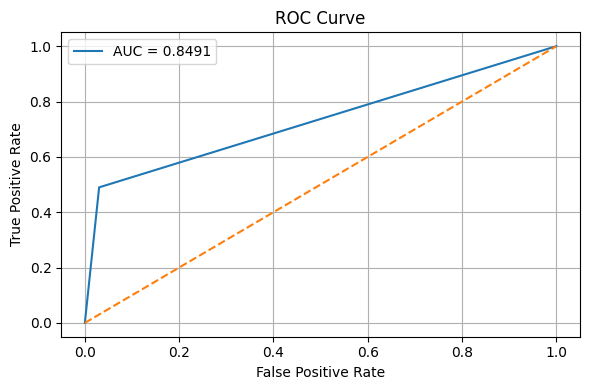

In [7]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

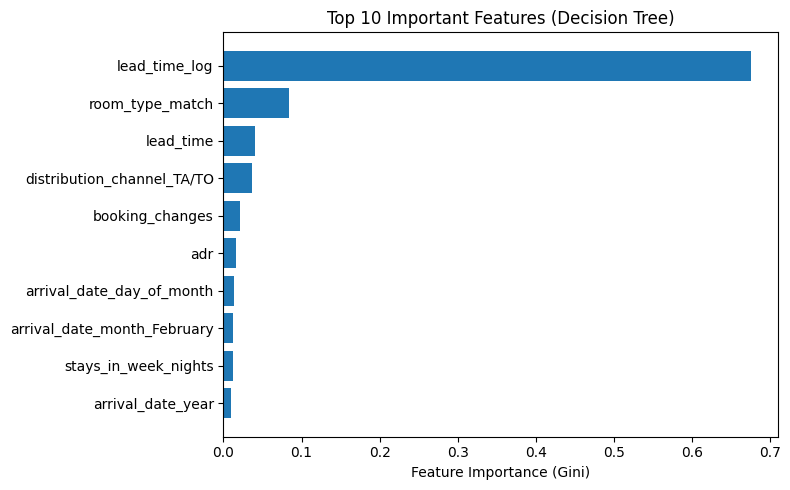

In [8]:
# Show top 10 feature importances
importances = final_model.feature_importances_
features = X_train_val.columns
top_idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(8, 5))
plt.barh(range(10), importances[top_idx][::-1])
plt.yticks(range(10), [features[i] for i in top_idx][::-1])
plt.xlabel("Feature Importance (Gini)")
plt.title("Top 10 Important Features (Decision Tree)")
plt.tight_layout()
plt.show()


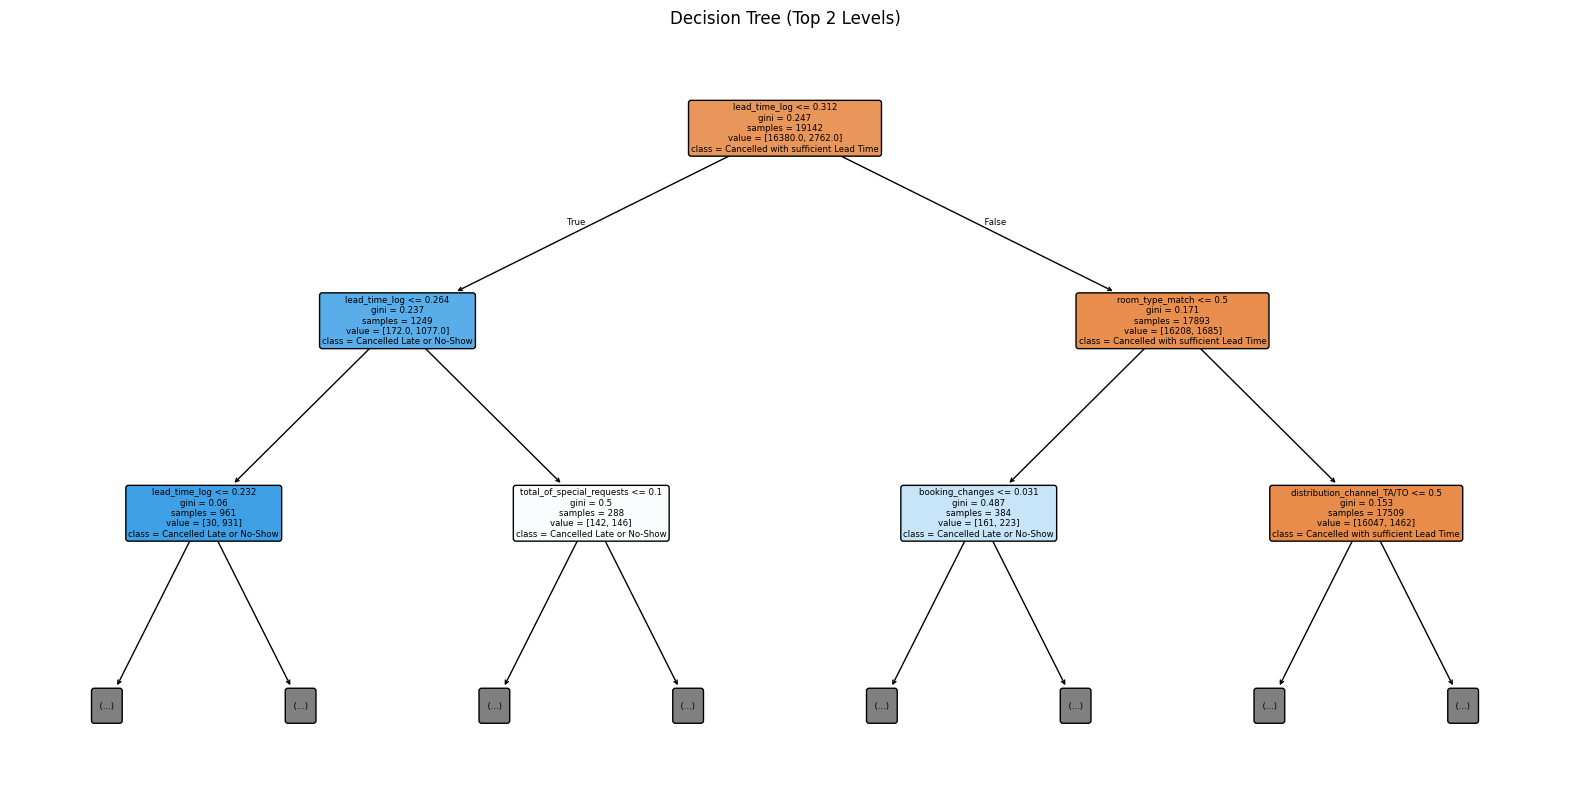

In [9]:
# Visualize the tree
levels_for_viz = 2
plt.figure(figsize=(20, 10))
plot_tree(final_model, feature_names=X_train_val.columns, class_names=["Cancelled with sufficient Lead Time", "Cancelled Late or No-Show"],
          filled=True, rounded=True, max_depth=levels_for_viz)  # keep short for readability
plt.title(f"Decision Tree (Top {levels_for_viz} Levels)")
plt.show()

In [51]:
# Split X and y *from the same filtered DataFrame* after creating `late_or_noshow`
cancelled_data = hotel_data[hotel_data['is_canceled'] == 1].copy()

# Split by date
last_date = cancelled_data['arrival_date'].max()
cutoff = last_date - pd.DateOffset(months=3)

train_data = cancelled_data[cancelled_data['arrival_date'] <= cutoff].copy()
test_data  = cancelled_data[cancelled_data['arrival_date'] >  cutoff].copy()

# Define features and target
X_train_raw = train_data.drop(columns=['reservation_status', 'reservation_status_date', 'arrival_date', 'days_before_arrival', 'is_canceled', 'late_or_noshow'])
y_train = train_data['late_or_noshow']

X_test_raw = test_data.drop(columns=['reservation_status', 'reservation_status_date', 'arrival_date', 'days_before_arrival', 'is_canceled', 'late_or_noshow'])
y_test = test_data['late_or_noshow']

def add_interactions(df):
    df['lead_time_x_deposit'] = df['lead_time'].astype(str) + '_' + df['deposit_type']
    df['lead_time_x_customer_type'] = df['lead_time'].astype(str) + '_' + df['customer_type']
    df['lead_time_x_market_segment'] = df['lead_time'].astype(str) + '_' + df['market_segment']
    df['adr_x_deposit'] = df['adr'].round(0).astype(str) + '_' + df['deposit_type']
    df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

    def tag_seasonal_weeks(week):
        if week in [51, 52, 1]: return 'christmas'
        elif week in [12, 13, 14, 15]: return 'spring_break'
        elif week in range(25, 36): return 'summer'
        elif week in [36, 37, 38]: return 'school_start'
        else: return 'off_peak'

    df['season_tag'] = df['arrival_date_week_number'].apply(tag_seasonal_weeks)
    df['lead_time_x_season'] = df['lead_time'].astype(str) + '_' + df['season_tag']

    return df

X_train_raw = add_interactions(X_train_raw)
X_test_raw = add_interactions(X_test_raw)

print("X_train:", X_train_raw.shape, "| y_train:", y_train.shape)
print("X_test: ", X_test_raw.shape, "| y_test: ", y_test.shape)


X_train: (37985, 36) | y_train: (37985,)
X_test:  (6239, 36) | y_test:  (6239,)


In [52]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Increase if needed

best_params = study.best_params

clf = Pipeline([
    ('preprocess', preprocessor),
    ('model', DecisionTreeClassifier(**best_params, random_state=42))
])

clf.fit(X_train_raw, y_train)

# Predict
y_pred = clf.predict(X_test_raw)
y_proba = clf.predict_proba(X_test_raw)[:, 1]

# Evaluation
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

print("\nBest parameters from Optuna:")
print(best_params)


[I 2025-06-20 02:04:36,171] A new study created in memory with name: no-name-168d165f-ea64-4299-a215-76566fd0b560
[I 2025-06-20 02:04:37,109] Trial 0 finished with value: 0.8253220181924286 and parameters: {'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 9, 'ccp_alpha': 0.0004869299283098631}. Best is trial 0 with value: 0.8253220181924286.
[I 2025-06-20 02:04:38,140] Trial 1 finished with value: 0.8052312856051357 and parameters: {'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 8, 'ccp_alpha': 0.0008145366584091193}. Best is trial 0 with value: 0.8253220181924286.
[I 2025-06-20 02:04:38,883] Trial 2 finished with value: 0.7938363217895807 and parameters: {'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 1, 'ccp_alpha': 0.0026366276501337414}. Best is trial 0 with value: 0.8253220181924286.
[I 2025-06-20 02:04:39,661] Trial 3 finished with value: 0.8000762653771931 and parameters: {'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 9, 'c


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5912
           1       0.87      0.43      0.57       327

    accuracy                           0.97      6239
   macro avg       0.92      0.71      0.78      6239
weighted avg       0.96      0.97      0.96      6239

ROC AUC: 0.8104011744112425

Best parameters from Optuna:
{'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 10, 'ccp_alpha': 0.00012549692382721674}


In [54]:
# Get one-hot encoded feature names
onehot = clf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
onehot_features = onehot.get_feature_names_out(cat_cols)

# Combine with numeric columns
all_features = list(onehot_features) + num_cols

import pandas as pd

# Get feature importances from tree
tree_model = clf.named_steps['model']
importances = tree_model.feature_importances_

# Assemble into DataFrame
feat_imp = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print top 20
print("\n=== Top 20 Feature Importances ===")
print(feat_imp.head(20).to_string(index=False))



=== Top 20 Feature Importances ===
                                      Feature  Importance
                                    lead_time    0.738099
        lead_time_x_market_segment_134_Groups    0.034566
                      deposit_type_Non Refund    0.030580
                                          adr    0.026987
                   distribution_channel_TA/TO    0.024355
lead_time_x_customer_type_116_Transient-Party    0.022603
                                        agent    0.010456
                adr_x_deposit_99.0_Non Refund    0.009705
                         stays_in_week_nights    0.009331
                     arrival_date_week_number    0.008348
lead_time_x_customer_type_110_Transient-Party    0.008029
 lead_time_x_market_segment_103_Offline TA/TO    0.007212
         lead_time_x_market_segment_35_Groups    0.007192
                                  country_FRA    0.006482
         lead_time_x_market_segment_19_Groups    0.006280
 lead_time_x_market_segment_290_Offl

## XGB Classifier

In [ ]:
# === Optuna objective ===
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'scale_pos_weight': (y_train_val == 0).sum() / (y_train_val == 1).sum(),
        'eval_metric': 'auc',
        'random_state': 42
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []

    for train_idx, val_idx in kf.split(X_train_val, y_train_val):
        X_tr = X_train_val.iloc[train_idx].reset_index(drop=True)
        y_tr = y_train_val.iloc[train_idx].reset_index(drop=True)
        X_val = X_train_val.iloc[val_idx].reset_index(drop=True)
        y_val = y_train_val.iloc[val_idx].reset_index(drop=True)

        model = XGBClassifier(**params)
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_pred)
        aucs.append(val_auc)

    return np.mean(aucs)

# === Run Optuna ===
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("\n=== Best Parameters ===")
print(study.best_params)

[I 2025-06-18 01:35:20,399] A new study created in memory with name: no-name-55fc4d9f-40d9-4091-9cb2-828171b9b485
[I 2025-06-18 01:35:34,789] Trial 0 finished with value: 0.8733505476721826 and parameters: {'max_depth': 9, 'learning_rate': 0.07898235772898855, 'n_estimators': 437, 'min_child_weight': 9, 'subsample': 0.5649012589769697, 'colsample_bytree': 0.5719028536923236, 'reg_alpha': 4.954881451153993, 'reg_lambda': 1.0309205396530152}. Best is trial 0 with value: 0.8733505476721826.
[I 2025-06-18 01:35:38,674] Trial 1 finished with value: 0.882728107524426 and parameters: {'max_depth': 6, 'learning_rate': 0.06777726922059671, 'n_estimators': 189, 'min_child_weight': 6, 'subsample': 0.6809058183833684, 'colsample_bytree': 0.5279746806534553, 'reg_alpha': 1.4257493639290657, 'reg_lambda': 3.2712243753719417}. Best is trial 1 with value: 0.882728107524426.
[I 2025-06-18 01:35:43,351] Trial 2 finished with value: 0.8770945179246736 and parameters: {'max_depth': 3, 'learning_rate': 0.1


=== Best Parameters ===
{'max_depth': 8, 'learning_rate': 0.011292051268387296, 'n_estimators': 478, 'min_child_weight': 4, 'subsample': 0.7149719904740401, 'colsample_bytree': 0.8483612540537617, 'reg_alpha': 4.9848817991314665, 'reg_lambda': 1.0181797569875155}


In [ ]:
THRESHOLD = 0.7

# === Evaluate final model with best params ===
best_params = study.best_params
best_params.update({
    'scale_pos_weight': (y_train_val == 0).sum() / (y_train_val == 1).sum(),
    'eval_metric': 'auc',
    'random_state': 42
})

model = XGBClassifier(**best_params)
model.fit(X_train_val, y_train_val)
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba >= THRESHOLD).astype(int)

test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"\nFinal Test ROC AUC: {test_auc:.4f}")

# === Classification report and confusion matrix ===
print(f"\nClassification Report (threshold {THRESHOLD}):")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Final Test ROC AUC: 0.8703

Classification Report (threshold 0.7):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4330
           1       0.70      0.53      0.60       294

    accuracy                           0.96      4624
   macro avg       0.83      0.76      0.79      4624
weighted avg       0.95      0.96      0.95      4624


Confusion Matrix:
[[4263   67]
 [ 139  155]]


In [ ]:
# === Feature Importances ===
importances = model.feature_importances_
feature_names = X_train_val.columns
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feat_imp_df.head(10))



Top 10 Feature Importances:
                       feature  importance
74         lead_time_bin_short    0.206723
73      lead_time_bin_same_day    0.171449
14             room_type_match    0.079175
31  distribution_channel_TA/TO    0.056819
34     deposit_type_Non Refund    0.039394
10               lead_time_log    0.035292
26    market_segment_Online TA    0.034682
0                    lead_time    0.033880
33     deposit_type_No Deposit    0.018879
58          agent_binned_240.0    0.018486
